# Quick Checkup Disease Prediction Model

## 1. Introduction
This notebook builds a comprehensive machine learning pipeline to predict diseases based on symptoms. 
The approach uses **Symptom Severity** weights, sorted to ensure the model is invariant to the order of input symptoms.

**Workflow:**
1.  **Data Loading & Cleaning**: Handling missing values and normalizing text.
2.  **Exploratory Data Analysis (EDA)**: Understanding disease distribution and symptom frequency.
3.  **Data Preprocessing**: Mapping symptoms to severity weights and applying sorted encoding.
4.  **Model Training**: Random Forest Classifier.
5.  **Evaluation**: Confusion Vector, Classification Report, and ROC-AUC Curves.

In [20]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier

import warnings
warnings.filterwarnings('ignore')

# Setup paths
BASE_DIR = os.path.dirname(os.getcwd())
DATA_PATH = os.path.join(BASE_DIR, 'datasets/quick_checkup/symptom-disease.csv')
SEVERITY_PATH = os.path.join(BASE_DIR, 'datasets/quick_checkup/Symptom-severity.csv')
MODEL_DIR = os.path.join(os.path.dirname(os.path.dirname(BASE_DIR)), 'assets/models/quick_checkup')

if not os.path.exists(MODEL_DIR):
    os.makedirs(MODEL_DIR)

## 2. Data Loading and Cleaning

In [21]:
# Load datasets
df = pd.read_csv(DATA_PATH)
severity_df = pd.read_csv(SEVERITY_PATH)

print(f"Dataset Shape: {df.shape}")
print(f"Severity Map Shape: {severity_df.shape}")

Dataset Shape: (4858, 18)
Severity Map Shape: (133, 2)


In [22]:
# Normalize string format (remove underscores, strip whitespace)
for col in df.columns:
    df[col] = df[col].str.replace('_',' ').str.strip()

severity_df['Symptom'] = severity_df['Symptom'].str.replace('_',' ').str.strip()

# Create Dictionary for O(1) Lookup
symptom_weights = dict(zip(severity_df['Symptom'], severity_df['weight']))

print("Sample of Symptom Weights:")
list(symptom_weights.items())[:5]

Sample of Symptom Weights:


[('itching', 1),
 ('skin rash', 3),
 ('nodal skin eruptions', 4),
 ('continuous sneezing', 4),
 ('shivering', 5)]

In [23]:
# Handle Missing Values (NaN -> 0/Empty)
df = df.fillna(0)
df.head()

,Disease,Symptom_1,Symptom_2,Symptom_3,Symptom_4,Symptom_5,Symptom_6,Symptom_7,Symptom_8,Symptom_9,Symptom_10,Symptom_11,Symptom_12,Symptom_13,Symptom_14,Symptom_15,Symptom_16,Symptom_17
0,Allergy,continuous sneezing,shivering,chills,watering from eyes,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Allergy,shivering,chills,watering from eyes,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Allergy,continuous sneezing,chills,watering from eyes,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Allergy,continuous sneezing,shivering,watering from eyes,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Allergy,continuous sneezing,shivering,chills,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## 3. Exploratory Data Analysis (EDA)

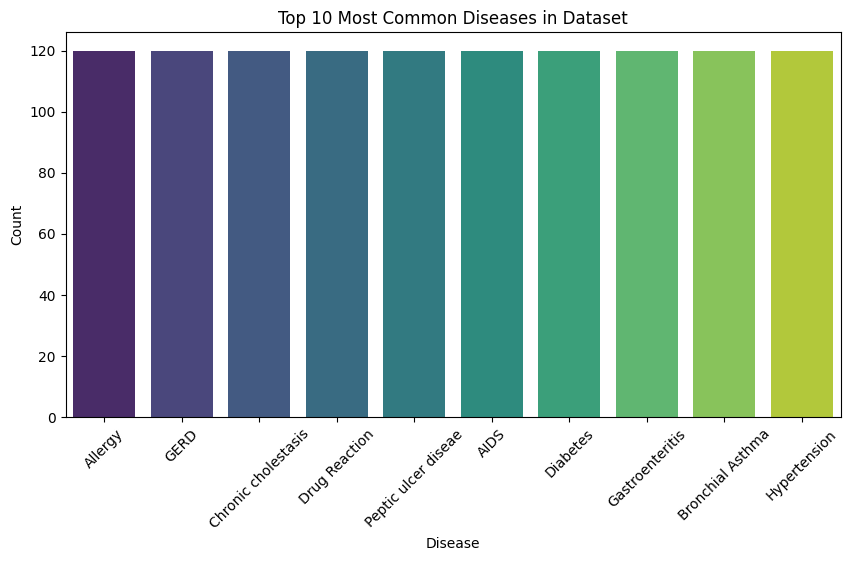

In [24]:
# Disease Distribution
plt.figure(figsize=(10, 5))
disease_counts = df['Disease'].value_counts()
sns.barplot(x=disease_counts.index[:10], y=disease_counts.values[:10], palette='viridis')
plt.title('Top 10 Most Common Diseases in Dataset')
plt.xticks(rotation=45)
plt.ylabel('Count')
plt.show()

In [25]:
# Check for Class Imbalance
print("Class Distribution Statistics:")
print(df['Disease'].value_counts().describe())
# Result: The dataset is perfectly balanced (120 samples per disease).

Class Distribution Statistics:
count     41.000000
mean     118.487805
std        9.682773
min       58.000000
25%      120.000000
50%      120.000000
75%      120.000000
max      120.000000
Name: count, dtype: float64


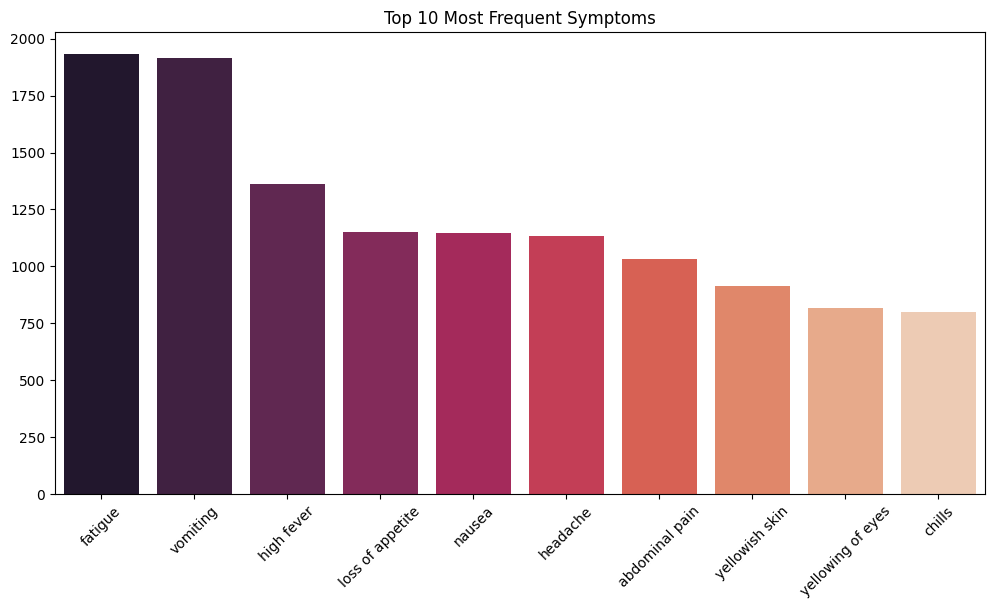

In [26]:
# Symptom Frequency Analysis
all_symptoms = []
symptom_cols = [col for col in df.columns if 'Symptom' in col]

for col in symptom_cols:
    symptoms = df[col].values
    all_symptoms.extend([s for s in symptoms if s != 0])

from collections import Counter
symptom_counts = Counter(all_symptoms)
common_symptoms = symptom_counts.most_common(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=[x[0] for x in common_symptoms], y=[x[1] for x in common_symptoms], palette='rocket')
plt.title('Top 10 Most Frequent Symptoms')
plt.xticks(rotation=45)
plt.show()

## 4. Data Preprocessing (Feature Engineering)
**Strategy:** Sorted Severity Weights.
- Each symptom is mapped to its integer weight.
- The weights for a patient are **sorted descending**.
- This ensures `[Itching, Rash]` -> `[3, 1]` and `[Rash, Itching]` -> `[3, 1]`, fixing positional bias.

In [27]:
X_list = []
y_list = []

for i, row in df.iterrows():
    weights = []
    for col in symptom_cols:
        symptom = row[col]
        if symptom != 0 and symptom in symptom_weights:
            weights.append(symptom_weights[symptom])
        else:
             # Pad with 0 for missing/empty slots
             weights.append(0)
    
    # FEATURE ENGINEERING: Sort Descending
    weights.sort(reverse=True)
    
    # Truncate/Pad to fixed length of 17 columns
    while len(weights) < 17:
        weights.append(0)
    weights = weights[:17]
    
    X_list.append(weights)
    y_list.append(row['Disease'])

X = np.array(X_list)
y = np.array(y_list)

print(f"Feature Matrix Shape: {X.shape}")
print(f"Target Vector Shape: {y.shape}")

Feature Matrix Shape: (4858, 17)
Target Vector Shape: (4858,)


## 5. Model Training

In [28]:
# Train-Test Split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Initialization
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## 6. Model Evaluation

In [29]:
# 6.1 Basic Metrics
preds = rf.predict(X_test)
acc = accuracy_score(y_test, preds)
print(f"Model Accuracy: {acc:.2%}")

# 6.2 Classification Report
print("\nClassification Report:")
print(classification_report(y_test, preds))

Model Accuracy: 97.63%

Classification Report:
                                         precision    recall  f1-score   support

(vertigo) Paroymsal  Positional Vertigo       1.00      0.96      0.98        28
                                   AIDS       0.88      0.96      0.92        23
                                   Acne       1.00      1.00      1.00        22
                    Alcoholic hepatitis       1.00      0.74      0.85        23
                                Allergy       0.96      1.00      0.98        24
                              Arthritis       1.00      1.00      1.00        16
                       Bronchial Asthma       1.00      1.00      1.00        18
                   Cervical spondylosis       0.79      0.88      0.83        17
                            Chicken pox       1.00      1.00      1.00        17
                    Chronic cholestasis       1.00      1.00      1.00        24
                            Common Cold       1.00      1.00 

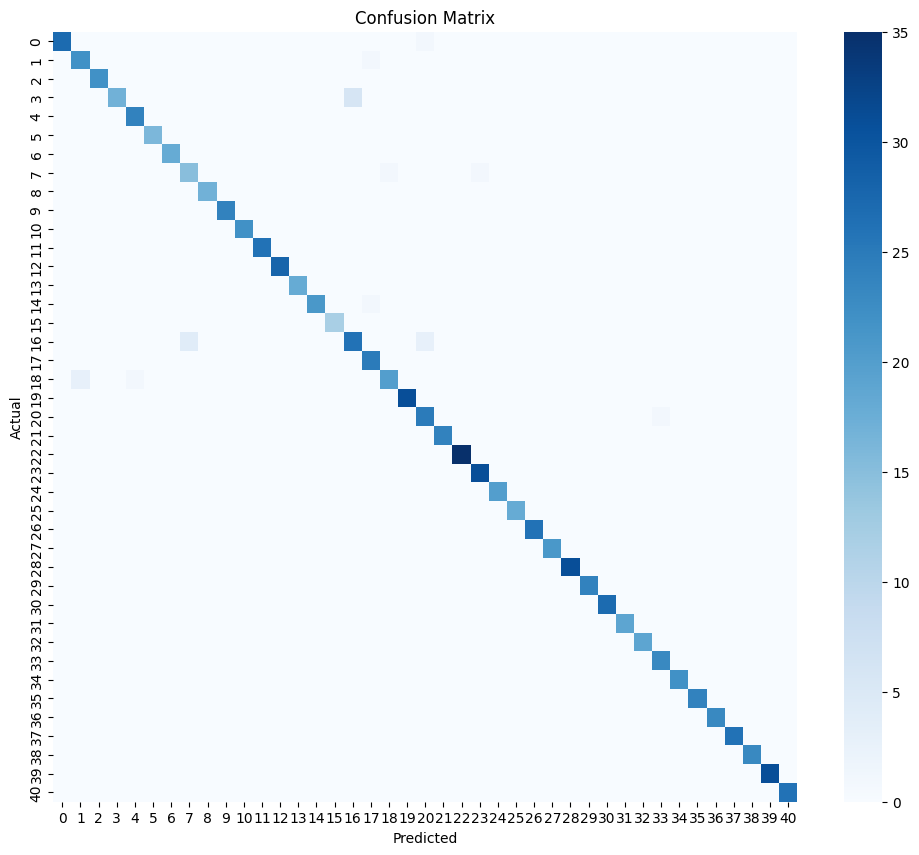

In [30]:
# 6.3 Confusion Matrix
plt.figure(figsize=(12, 10))
cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=False, cmap='Blues') # Too many classes for annotation
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

### 6.4 ROC - AUC Curve (Multiclass)
To plot ROC curves for multiclass classification, we use the One-vs-Rest strategy.

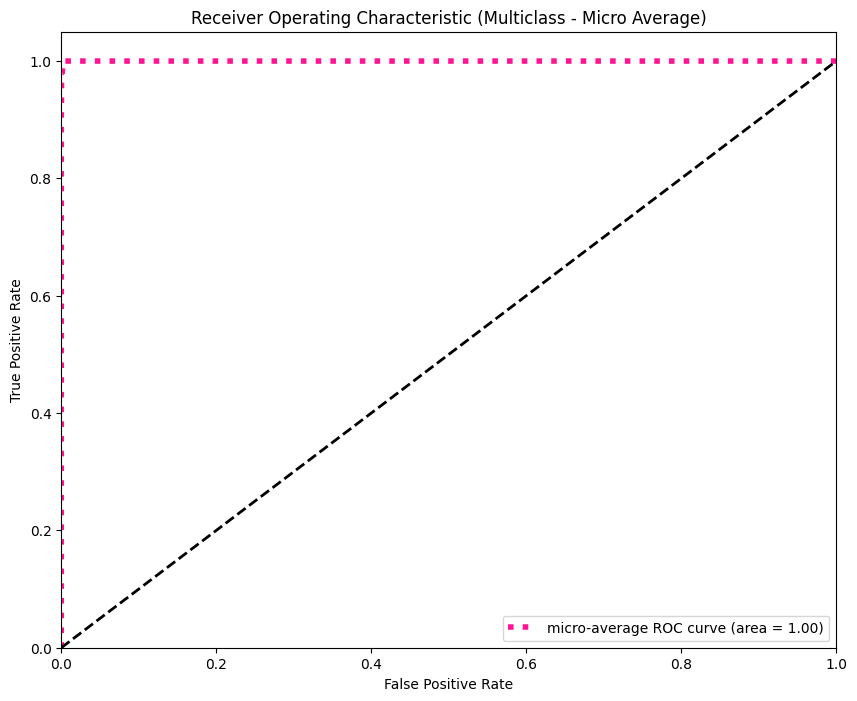

In [31]:
# Binarize the output
classes = np.unique(y)
y_test_bin = label_binarize(y_test, classes=classes)
n_classes = y_test_bin.shape[1]

# Learn to predict each class against the other
classifier = OneVsRestClassifier(RandomForestClassifier(n_estimators=100, random_state=42))
y_score = classifier.fit(X_train, label_binarize(y_train, classes=classes)).predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test_bin.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Plot ROC curve for a subset of classes (to avoid clutter)
plt.figure(figsize=(10, 8))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (Multiclass - Micro Average)')
plt.legend(loc="lower right")
plt.show()

## 7. Saving the Model
Finally, we save the trained model and the symptom weights dictionary for the backend service.

In [32]:
joblib.dump(rf, os.path.join(MODEL_DIR, 'rf_QuickCheckup.joblib'))
joblib.dump(symptom_weights, os.path.join(MODEL_DIR, 'symptom_weights.joblib'))
print("Model and weights saved successfully.")

Model and weights saved successfully.
